In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
outcomesDf = pd.read_csv('./outcomes.tsv',sep='\t')
tracesDf = pd.read_csv('./traces.tsv',sep='\t')

In [4]:
outcomesDf.head(2)

,auction_id,product_id,item,desc,retail,price,finalprice,bidincrement,bidfee,winner,placedbids,freebids,endtime_str,flg_click_only,flg_beginnerauction,flg_fixedprice,flg_endprice
0,86827,10009602,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,13.35,13.35,15,75,Racer11,26,0,19:52 PDT 09-16-2008,0,0,0,0
1,87964,10009881,psp-slim-lite-sony-piano-black,PSP Slim & Lite Sony Piano Black,169.99,74.70,74.70,15,75,Cemo23,65,0,11:17 PDT 08-28-2008,0,0,0,0


In [3]:
outcomesDf.dtypes

auction_id               int64
product_id               int64
item                    object
desc                    object
retail                 float64
price                  float64
finalprice             float64
bidincrement             int64
bidfee                   int64
winner                  object
placedbids               int64
freebids                 int64
endtime_str             object
flg_click_only           int64
flg_beginnerauction      int64
flg_fixedprice           int64
flg_endprice             int64
dtype: object

In [3]:
pd.options.display.max_rows= 20

In [3]:
outcomesDf['endtime_str'] = pd.to_datetime(outcomesDf['endtime_str'])

Número de ganadores:

In [4]:
outcomesDf['bids_placed'] = outcomesDf['price']/(outcomesDf['bidincrement']/100)

In [5]:
outcomesDf['swoopo_sale_price'] = outcomesDf['bids_placed']*(outcomesDf['bidfee']/100) + outcomesDf['finalprice']

In [6]:
outcomesDf['swoopo_profit'] = outcomesDf['swoopo_sale_price']-outcomesDf['retail']

In [8]:
len(outcomesDf['winner'].unique())

45787

In [21]:
min(outcomesDf['endtime_str'])

Timestamp('2008-08-20 14:04:00')

In [22]:
max(outcomesDf['endtime_str'])

Timestamp('2009-12-12 15:10:00')

In [17]:
outcomesDfItemDesc =outcomesDf[['item','desc']]
outcomesDfItemDesc.head()
outcomesDfItemDesc.shape
itemColumnValueCounts = outcomesDf['item'].value_counts()
itemColumnValueCounts.head()
outcomesDfItemDesc.shape
outcomesDfItemDesc = outcomesDfItemDesc.merge(itemColumnValueCounts.to_frame(),how='left',left_on='item',right_index=True)
outcomesDfItemDesc = outcomesDfItemDesc.rename(columns={'item_x': 'item', 'item_y': 'item_count'})
outcomesDfItemDesc.shape
outcomesDfItemDesc
descColumnValueCounts = outcomesDf['desc'].value_counts()
descColumnValueCounts.head()
outcomesDfItemDesc = outcomesDfItemDesc.merge(descColumnValueCounts.to_frame(),how='left',left_on='desc',right_index=True)
outcomesDfItemDesc = outcomesDfItemDesc.rename(columns={'desc_x': 'desc', 'desc_y': 'desc_count'})
outcomesDfItemDesc.shape
outcomesDfItemDesc.head()
outcomesDfItemDesc[outcomesDfItemDesc['item_count']!=outcomesDfItemDesc['desc_count']]['item'].unique()

array(['mario-sonic-at-the-olympic-winter-games-',
       'star-wars-the-clone-wars-republic-heroes'], dtype=object)

In [16]:
outcomesDf.loc[outcomesDf['item'].values=="vtech-v-smile-tv-learning-system", 'desc'] = "Vtech - V.Smile TV Learning System"
outcomesDf.loc[outcomesDf['item'].values=="lego-city-7743-police-command-center", 'desc'] = "LEGO City 7743 - Police Command Center"
outcomesDf.loc[outcomesDf['item'].values=="samsung-t220hd-22-1080p-lcd-hdtv-monitor", 'desc'] = "Samsung T220HD 22\" 1080p LCD HDTV Monitor"
outcomesDf.loc[outcomesDf['item'].values=="ghd-professional-mini-styler-mk4-5-8-inc", 'desc'] = "GHD Professional Mini Styler MK4 (5/8\" Inch)"
outcomesDf.loc[outcomesDf['item'].values=="frigidaire-atf8000fs-white-front-loading", 'desc'] = "Frigidaire ATF8000FS White Front-Loading Washer"
outcomesDf.loc[outcomesDf['item'].values=="lg-26-5-cu-ft-side-by-side-refrigerator-", 'desc'] = "LG 26.5 cu.ft. Side-By-Side Refrigerator (White)"
outcomesDf.loc[outcomesDf['item'].values=="samsung-bd-p3600-1080p-blu-ray-disc-play", 'desc'] = "Samsung BD-P3600 1080p Blu-Ray Disc Player"
outcomesDf.loc[outcomesDf['item'].values=="garmin-n-vi-205w-4-3-inch-portable-gps-n", 'desc'] = "Garmin nüvi 205W 4.3-Inch Portable GPS Navigator"
outcomesDf.loc[outcomesDf['item'].values=="casio-exilim-ex-z200-10-1-mp-digital-cam", 'desc'] = "Casio Exilim EX-Z200 10.1 MP Digital Camera"

htmlItems = ['109104.html', '109746.html', '109786.html', '109830.html',
       '110013.html', '110869.html', '111506.html', '111584.html',
       '112103.html', '112187.html', '114652.html', '114804.html',
       '114907.html', '116626.html', '117910.html', '118838.html',
       '121129.html', '121215.html', '121470.html', '121471.html',
       '121788.html', '121881.html', '123276.html', '123553.html',
       '125284.html', '125285.html', '125286.html', '125287.html',
       '125288.html', '126865.html', '126866.html', '126867.html','130108.html',
       '137897.html', '137898.html', '140035.html']
outcomesDf = outcomesDf[~outcomesDf['item'].isin(htmlItems)]

In [15]:
outcomesDfItemDesc[outcomesDfItemDesc['item'].values=="casio-exilim-ex-z200-10-1-mp-digital-cam"]['desc'].unique()

array(['Casio Exilim EX-Z200 10.1 MP Digital Camera - RED',
       'Casio Exilim EX-Z200 10.1 MP Digital Camera'], dtype=object)

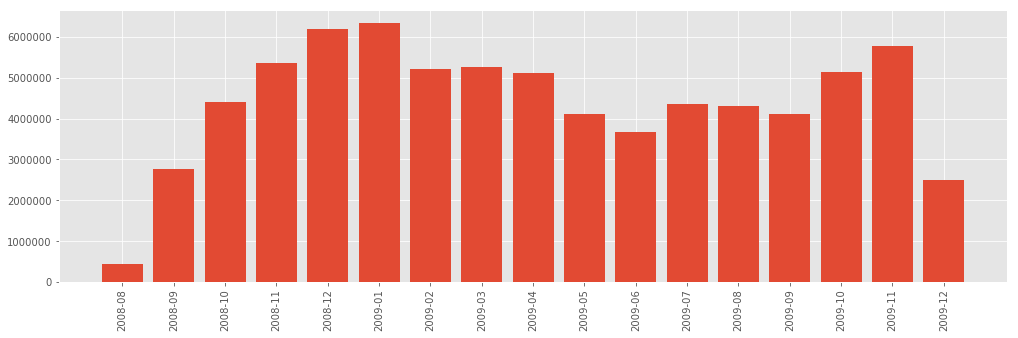

In [12]:
f = lambda x: str(x.year) + '-' + '{0:02d}'.format(x.month)

grupo = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['bids_placed'].sum()

X=grupo.values
Y=grupo.index

plt.figure(figsize=(17,5))
plt.bar(range(len(X)), X)
plt.xticks(np.arange(len(X)), Y,rotation='vertical')
plt.show()

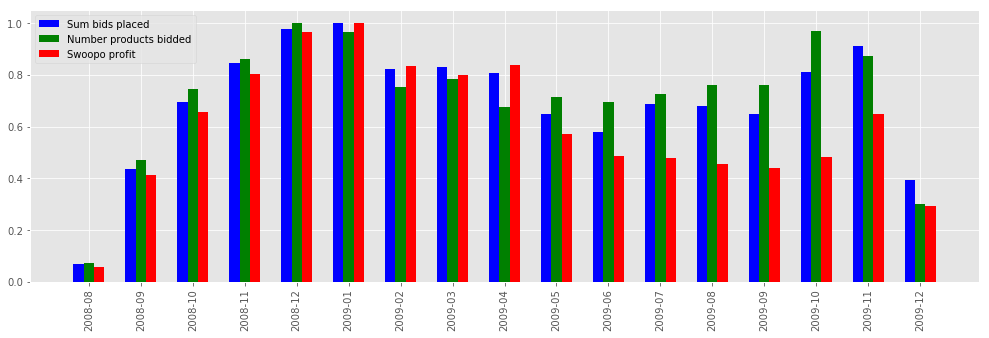

In [37]:
f = lambda x: str(x.year) + '-' + '{0:02d}'.format(x.month)

sumBidsPlacedGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['bids_placed'].sum()
countProductsBiddedGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['bids_placed'].count()
swoopoProfitGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['swoopo_profit'].sum()

X=sumBidsPlacedGroup.index
Y=sumBidsPlacedGroup.values
Y2 = countProductsBiddedGroup.values
Y3 = swoopoProfitGroup.values
bar_width = 0.20

plt.figure(figsize=(17,5))
p1=plt.bar(np.arange(len(Y)),Y/max(Y), bar_width,color='b')
p2=plt.bar(np.arange(len(Y2))+bar_width,Y2/max(Y2),bar_width, color='g')
p3=plt.bar(np.arange(len(Y3))+2*bar_width,Y3/max(Y3),bar_width, color='r')
plt.xticks(np.arange(len(X)) + bar_width, X,rotation='vertical')
plt.legend((p1,p2,p3),('Sum bids placed','Number products bidded', 'Swoopo profit'))
plt.show()

In [16]:
np.arange(4)

array([0, 1, 2, 3])

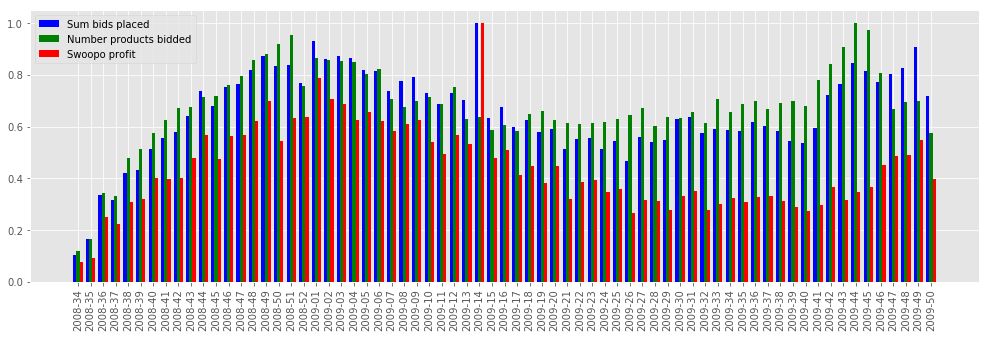

In [41]:
def timeStampToYearWeekFormat(timestamp):
    
    #for index_val, series_val in timeStampSeries.iteritems():
    yearWeekFormatString = str(timestamp.year) + '-' + '{0:02d}'.format(timestamp.weekofyear)
    if yearWeekFormatString == '2008-01':
        #Convert 2008-01 to 2009-01, because some days of the last week of 
        #a year are considered to be in the first week of the next year, 
        #and the data timestamps range from '2008-08-20 14:04:00' to '2009-12-12 15:10:00'
        #The ISO 8601 definition for week 01 is the week with the year's first Thursday in it.
        yearWeekFormatString = '2009-01'
    return yearWeekFormatString
    
sumBidsPlacedGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(timeStampToYearWeekFormat))['bids_placed'].sum()
countProductsBiddedGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(timeStampToYearWeekFormat))['bids_placed'].count()
swoopoProfitGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(timeStampToYearWeekFormat))['swoopo_profit'].sum()

X=sumBidsPlacedGroup.index
Y=sumBidsPlacedGroup.values
Y2 = countProductsBiddedGroup.values
Y3 = swoopoProfitGroup.values
bar_width = 0.25

plt.figure(figsize=(17,5))
p1=plt.bar(np.arange(len(Y)),Y/max(Y), bar_width,color='b')
p2=plt.bar(np.arange(len(Y2))+bar_width,Y2/max(Y2),bar_width, color='g')
p3=plt.bar(np.arange(len(Y3))+2*bar_width,Y3/max(Y3),bar_width, color='r')
plt.xticks(np.arange(len(X)) + bar_width, X,rotation='vertical')
plt.legend((p1,p2,p3),('Sum bids placed','Number products bidded', 'Swoopo profit'))
plt.show()


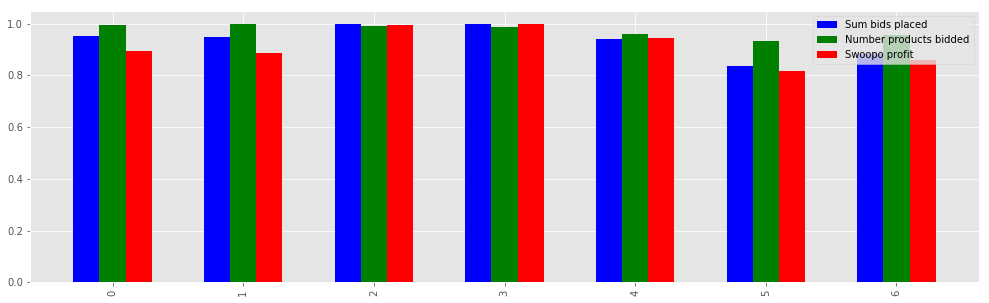

In [38]:
f = lambda x: str(x.dayofweek)

sumBidsPlacedGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['bids_placed'].sum()
countProductsBiddedGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['bids_placed'].count()
swoopoProfitGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['swoopo_profit'].sum()

X=sumBidsPlacedGroup.index
Y=sumBidsPlacedGroup.values
Y2 = countProductsBiddedGroup.values
Y3 = swoopoProfitGroup.values
bar_width = 0.20

plt.figure(figsize=(17,5))
p1=plt.bar(np.arange(len(Y)),Y/max(Y), bar_width,color='b')
p2=plt.bar(np.arange(len(Y2))+bar_width,Y2/max(Y2),bar_width, color='g')
p3=plt.bar(np.arange(len(Y3))+2*bar_width,Y3/max(Y3),bar_width, color='r')
plt.xticks(np.arange(len(X)) + bar_width, X,rotation='vertical')
plt.legend((p1,p2,p3),('Sum bids placed','Number products bidded', 'Swoopo profit'))
plt.show()

In [14]:
def timeStampToYearWeekFormat(timestamp):
    
    #for index_val, series_val in timeStampSeries.iteritems():
    yearWeekFormatString = str(timestamp.year) + '-' + '{0:02d}'.format(timestamp.weekofyear)
    if yearWeekFormatString == '2008-01':
        #Convert 2008-01 to 2009-01, because some days of the last week of 
        #a year are considered to be in the first week of the next year, 
        #and the data timestamps range from '2008-08-20 14:04:00' to '2009-12-12 15:10:00'
        #The ISO 8601 definition for week 01 is the week with the year's first Thursday in it.
        yearWeekFormatString = '2009-01'
    return yearWeekFormatString
    
grupo = outcomesDf.groupby(outcomesDf['endtime_str'].apply(timeStampToYearWeekFormat))['endtime_str']

grupo.unique()


endtime_str
2008-34    [2008-08-23T22:02:00.000000000, 2008-08-24T14:...
2008-35    [2008-08-28T11:17:00.000000000, 2008-08-25T11:...
2008-36    [2008-09-02T06:21:00.000000000, 2008-09-02T00:...
2008-37    [2008-09-08T08:26:00.000000000, 2008-09-14T23:...
2008-38    [2008-09-16T19:52:00.000000000, 2008-09-18T10:...
2008-39    [2008-09-23T10:08:00.000000000, 2008-09-23T18:...
2008-40    [2008-10-04T00:59:00.000000000, 2008-09-29T22:...
2008-41    [2008-10-10T13:32:00.000000000, 2008-10-08T05:...
2008-42    [2008-10-15T09:50:00.000000000, 2008-10-17T10:...
2008-43    [2008-10-21T09:28:00.000000000, 2008-10-25T08:...
                                 ...                        
2009-41    [2009-10-05T10:51:00.000000000, 2009-10-05T01:...
2009-42    [2009-10-12T00:00:00.000000000, 2009-10-12T00:...
2009-43    [2009-10-19T06:13:00.000000000, 2009-10-19T06:...
2009-44    [2009-10-27T13:55:00.000000000, 2009-10-30T14:...
2009-45    [2009-11-02T00:18:00.000000000, 2009-11-02T06:...
2009-46    [

In [7]:
outcomesDf['winner'].value_counts()

HH0812          131
Oglalasioux     117
Toertchen       116
Koboldwicht     112
Schlumpf01      111
Kavvamartin     111
Thomsen321      109
Brusher         108
Aluf412         108
Trixi101        106
Maths           105
18rudi61        104
HFW-BW          104
Samurai38       103
1pleitegeier    102
waggerl         102
winni1958       101
canton          101
rasputin900     101
19conny63       101
Kaiserlein99    101
Biggibig        100
kiam20          100
damage24        100
Redfoxz          99
Artemis412       98
Albundy12        98
audt             97
buvosc           97
XX1973XX         95
               ... 
Sinow             1
Ahmedhans         1
Rudnik02          1
Zachias87         1
Abseitsfalle      1
Murdock04         1
Antware           1
Becisoft          1
Larry1968         1
Conmigo27         1
Spearo1985        1
Sandizm           1
Tomb578           1
Emolson           1
Titan1986         1
Srmorgen          1
Tayloa            1
Morzy             1
Monstar13         1


In [8]:
outcomesDf['desc'].value_counts()

20 Bids Voucher                                      6658
Wii | Nintendo Console + Wii Sports                  5935
50 Bids Voucher                                      3283
300 Bids Voucher                                     2365
50 FreeBids Voucher                                  2297
Wii Fit | Nintendo WiiFit + Balance Board            2179
75 Bids Voucher                                      2073
Mario Kart with Wheel (Nintendo Wii)                 1995
DS | Nintendo DS Lite Black                          1754
Sony PlayStation 3 80 GB                             1656
300 FreeBids Voucher                                 1503
Corsair Voyager Mini 4 GB USB Flash                  1452
Apple iPod touch 8 GB (new generation)               1305
Transcend TS8GJFV10 USB 2.0 8GB Flash Drive          1239
Nikon D90 12.3 MP DSLR Camera with 18-105mm Kit      1160
DS | Nintendo DS Lite (silver)                       1113
TomTom Go 930T                                       1048
Kingston DataT

In [6]:
outcomesDf.head()

,auction_id,product_id,item,desc,retail,price,finalprice,bidincrement,bidfee,winner,placedbids,freebids,endtime_str,flg_click_only,flg_beginnerauction,flg_fixedprice,flg_endprice
0,86827,10009602,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,13.35,13.35,15,75,Racer11,26,0,19:52 PDT 09-16-2008,0,0,0,0
1,87964,10009881,psp-slim-lite-sony-piano-black,PSP Slim & Lite Sony Piano Black,169.99,74.70,74.70,15,75,Cemo23,65,0,11:17 PDT 08-28-2008,0,0,0,0
2,87965,10009881,psp-slim-lite-sony-piano-black,PSP Slim & Lite Sony Piano Black,169.99,83.10,83.10,15,75,Jacobsonnich,94,0,22:52 PDT 11-07-2008,0,1,0,0
3,88638,10006115,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,19.65,19.65,15,75,Mokkis,10,0,22:02 PDT 08-23-2008,0,0,0,0
4,88639,10006115,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,47.10,47.10,15,75,Superloeffel,80,0,14:23 PDT 08-24-2008,0,0,0,0


In [6]:
outcomesDf['bidincrement'] = outcomesDf['bidincrement']/100
outcomesDf['bidfee'] = outcomesDf['bidfee']/100

In [7]:
outcomesDf['finalprice_withbids'] = outcomesDf['finalprice'] + outcomesDf['placedbids']*outcomesDf['bidfee']/100

In [8]:
X = outcomesDf[["retail","bidincrement","bidfee","flg_click_only","flg_beginnerauction","flg_fixedprice","flg_endprice"]].values
y = outcomesDf["finalprice"]

In [9]:
from sklearn.ensemble import RandomForestRegressor
rmodel=RandomForestRegressor()
rmodel.fit(X,y)
outcomesDf['P_finalprice'] = rmodel.predict(outcomesDf[["retail","bidincrement","bidfee","flg_click_only","flg_beginnerauction","flg_fixedprice","flg_endprice"]])

In [10]:
from sklearn.metrics import mean_squared_error
mean_squared_error(outcomesDf["finalprice"],outcomesDf["P_finalprice"])

1573.6795392862487

In [11]:
from sklearn.neighbors import KNeighborsRegressor
clf = KNeighborsRegressor(n_neighbors=14)
clf.fit(X, y)
mean_squared_error(outcomesDf["finalprice"],clf.predict(X))

1853.8693434612576

In [12]:
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor(max_depth=5)
clf.fit(X, y)
mean_squared_error(outcomesDf["finalprice"],clf.predict(X))

2233.3352624535119

In [13]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(X, y)
mean_squared_error(outcomesDf["finalprice"],clf.predict(X))

2836.4416671023268

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [15]:
from sklearn.pipeline import Pipeline
from sklearn import decomposition
from sklearn.ensemble import RandomForestRegressor

In [16]:
red = decomposition.PCA()
clf = RandomForestRegressor()
pipe = Pipeline(steps=[('pca', red), ('Random Forest',clf)])
pipe.fit(X_train,y_train)
mean_squared_error(y_test,pipe.predict(X_test))

1745.152500657724

In [17]:
rmodel=RandomForestRegressor()
rmodel.fit(X_train,y_train)
mean_squared_error(y_test,rmodel.predict(X_test))

1730.53876673115

In [21]:
#pip install tpot
from tpot import TPOTRegressor
clf = TPOTRegressor(generations=5, population_size=20, cv=5,
                                    random_state=42, verbosity=2)
clf.fit(X_train, y_train)

Optimization Progress:  35%|███▌      | 42/120 [19:18<23:49, 18.33s/pipeline]  

Generation 1 - Current best internal CV score: -1827.8826756451847


Optimization Progress:  52%|█████▏    | 62/120 [23:34<14:18, 14.80s/pipeline]

Generation 2 - Current best internal CV score: -1823.8761482971022


Optimization Progress:  68%|██████▊   | 82/120 [32:51<11:32, 18.22s/pipeline]

Generation 3 - Current best internal CV score: -1816.638711479889


Optimization Progress:  85%|████████▌ | 102/120 [40:59<08:24, 28.00s/pipeline]

Generation 4 - Current best internal CV score: -1812.5731728550006


Generation 5 - Current best internal CV score: -1809.5113192722783

Best pipeline: RandomForestRegressor(RobustScaler(input_matrix), bootstrap=True, max_features=0.95, min_samples_leaf=8, min_samples_split=9, n_estimators=100)


TPOTRegressor(config_dict={'sklearn.linear_model.ElasticNetCV': {'l1_ratio': array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ]), 'tol': [1e-05, 0.0001, 0.001, 0.01, 0.1]}, 'sklearn.ensemble.ExtraT....45,
        0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,
        0.95,  1.  ])}}}},
       crossover_rate=0.1, cv=5, disable_update_check=False,
       early_stop=None, generations=5, max_eval_time_mins=5,
       max_time_mins=None, memory=None, mutation_rate=0.9, n_jobs=1,
       offspring_size=20, periodic_checkpoint_folder=None,
       population_size=20, random_state=42, scoring=None, subsample=1.0,
       verbosity=2, warm_start=False)

In [24]:
mean_squared_error(y_test,clf.predict(X_test))

1700.5002792679786